In [6]:
def get_wikis():
    # data frame instance for storing each row
    dataFrame = pd.DataFrame(columns=['id', 'title', 'content'])
    
    # looping for fetching all available wikis fron DB
    # manually tested for max ranges of limit & offeset,
    # came out to be limit = 50 & offeset = 1337
    for offset in range(0,1340,50):
        # graphql db url for everpedia wikis
        url = "https://graph.everipedia.org/graphql"
        # payload 
        query = """{
                      wikis(limit:50,offset:"""+str(offset)+""") {
                      id
                      title
                      content
                    }
                }"""
        
        # sending request
        response = requests.post(url=url,json={"query":query})
        #time.sleep(0.5)
        # storing newly fetched data into a data frame
        freshDf = pd.DataFrame(response.json()['data']['wikis'])
        
        # concatenating both old & new dataframes as one
        dataFrame = pd.concat([dataFrame, freshDf],axis=0,ignore_index=True)
        
    # DB may return same wiki multiple times from each request, so drop duplicates if any  
    dataFrame = dataFrame.drop_duplicates(subset=['id']) # id is the unique identifier
    
    return dataFrame

In [7]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import pandas as pd
import requests
import time

In [9]:
df = get_wikis()

In [12]:
df

,wikiid,title,content
0,deafbeef,Deafbeef,**Deafbeef** is a generative audiovisual [NFT]...
1,white-paper,White Paper,A **whitepaper** is a document released by dev...
2,limit-break,Limit Break,Limit Break is a [blockchain](https://iq.wiki/...
3,digidaigaku,DigiDaigaku,**DigiDaigaku** is a collection of unique [non...
4,luis-cuende,Luis Cuende,**Luis Cuende** is a software developer best k...
...,...,...,...
1345,bulls-on-the-block,Bulls on the Block,Bulls on the Block is a Non-Fungible Tokens (N...
1346,bryan-brinkman,Bryan Brinkman,Bryan Brinkman is a cartoon animator from the ...
1347,bold-badgers-squad,Bold Badgers Squad,"Bold Badgers Squad is a collection of 10,000 u..."
1348,blake-kathryn,Blake Kathryn,Blake Kathryn is a Los Angeles-based multidisc...


In [11]:
df.rename(columns={df.columns[0]: 'wikiid'}, inplace=True)

In [13]:
import re
from typing import List

HEADING_REGEX = re.compile(r'^#+ .*$')
WIDGET_REGEX = re.compile(r'^\$\$widget\d(.*?\))\$\$$')
MARKDOWN_LINK_REGEX = re.compile(r'^\[(.*)\]\(.*\)$')
MARKDOWN_IMAGE_REGEX = re.compile(r'^!\[.*\]\(.*\)$')
CITATION_REGEX = re.compile(r'\[\\\[\d+\\\]\]\(#cite-id-[a-z0-9]+\)', flags=re.MULTILINE)

MAX_PARA_COUNT = 3
MAX_CONTENT_LENGTH = 10000


def sanitize_content(content: str) -> str:
    
    """
    This function takes a string `content` that represents a Markdown document.
    It splits the document into paragraphs, filters out any paragraphs that do
    not contain valid text, removes Markdown syntax from the remaining paragraphs,
    and joins them back together into a string. The resulting string is trimmed
    to a maximum length and returned.
    """
        
    content_paragraphs = content.split('\n\n')
    filtered_paragraphs = [
        p for p in content_paragraphs if is_valid_paragraph(p)
    ]
    sanitized_paragraphs = []
    count = 0

    for paragraph in filtered_paragraphs:
        if count >= MAX_PARA_COUNT:
            break

        trimmed_paragraph = paragraph.strip()
        plain_text_paragraph = remove_markdown_syntax(trimmed_paragraph)
        sanitized_paragraph = CITATION_REGEX.sub('', plain_text_paragraph)
        is_heading = HEADING_REGEX.match(trimmed_paragraph) is not None

        if not is_heading:
            sanitized_paragraphs.append(sanitized_paragraph)
            count += 1
        else:
            sanitized_paragraphs.append(trimmed_paragraph)

    trimmed_content = '\n\n'.join(sanitized_paragraphs)[:MAX_CONTENT_LENGTH]

    return trimmed_content


def is_valid_paragraph(paragraph: str) -> bool:
    """
    This function takes a string `paragraph` and checks if it is a valid
    paragraph. A valid paragraph is one that contains text (i.e., is not empty),
    and does not contain Markdown image syntax, link syntax, or widget syntax.
    """
        
    para = paragraph.strip()
    return (
        len(para) != 0
        and not MARKDOWN_IMAGE_REGEX.match(para)
        and not MARKDOWN_LINK_REGEX.match(para)
        and not WIDGET_REGEX.match(para)
    )


def remove_markdown_syntax(text: str) -> str:
    
    """
    This function takes a string `paragraph` and checks if it is a valid
    paragraph. A valid paragraph is one that contains text (i.e., is not empty),
    and does not contain Markdown image syntax, link syntax, or widget syntax.
    """
        
    # Remove emphasis syntax
    text = re.sub(r'\*\*?(.*?)\*\*?', r'\1', text)
    text = re.sub(r'__(.*?)__', r'\1', text)

    # Remove code syntax
    text = re.sub(r'`(.+?)`', r'\1', text)

    # Remove links
    text = re.sub(r'\[(.*?)\]\((.*?)\)', r'\1', text)

    # Remove images
    text = re.sub(r'!\[(.*?)\]\((.*?)\)', r'', text)

    return text

def clean(string):
    sample = string

    cleaned = re.sub(r'\xa0',' ',
                    re.sub(r'\s{2,}',' ',
                       re.sub(r'\>','',
                              re.sub(r'\$\$widget0 YOUTUBE@VID\$\$','',
                                    re.sub(r'[#*]+','',
                                          re.sub(r'\\\[\d+\\\]','',
                                                sample))))))
    return cleaned

In [14]:
df.content = df.content.apply(sanitize_content)

In [15]:
df.content = df.content.apply(clean)

In [16]:
df.head()

,wikiid,title,content
0,deafbeef,Deafbeef,Deafbeef is a generative audiovisual NFT artis...
1,white-paper,White Paper,A whitepaper is a document released by develop...
2,limit-break,Limit Break,Limit Break is a blockchain gaming company tha...
3,digidaigaku,DigiDaigaku,DigiDaigaku is a collection of unique non-fung...
4,luis-cuende,Luis Cuende,Luis Cuende is a software developer best known...


In [18]:
df.iloc[0, 2]

'Deafbeef is a generative audiovisual NFT artist who creates music and visual art using a 10-year-old computer and a C compiler. The artist has a background in electrical engineering, sound recording, and music. Early Life & Education The artist grew up in rural Ontario, Canada. “We lived several miles away from the nearest village. And this was back in a time where you were free from the constant bombardment of information – so, my default state was being bored and I had to search out things to maintain my interest. Music was one of those.” - Deafbeef Throughout his early years, DEAFBEEF\'s passion for music and his struggle to reconcile it with the technical side of his intellect was a recurring theme. Initially, he considered studying music but eventually chose engineering instead. After becoming immersed in the music of Frank Zappa, he decided to pursue music. He built a recording studio and moved to Toronto at the age of 22, where he rented a warehouse space that also served as hi

In [19]:
!pip install -qU langchain tiktoken matplotlib seaborn tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 477.2/477.2 KB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 KB 6.3 MB/s eta 0:00:00


In [20]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

In [21]:
# Applying the tiktoken_len function to the content column and storing results in a list
token_lengths = [tiktoken_len(content) for content in df['content']]

# Calculate min, max, and average token lengths
min_token_length = min(token_lengths)
max_token_length = max(token_lengths)
average_token_length = sum(token_lengths) / len(token_lengths)

print(f"Minimum token length: {min_token_length}")
print(f"Maximum token length: {max_token_length}")
print(f"Average token length: {average_token_length}")

Minimum token length: 126
Maximum token length: 2371
Average token length: 1042.7881481481481


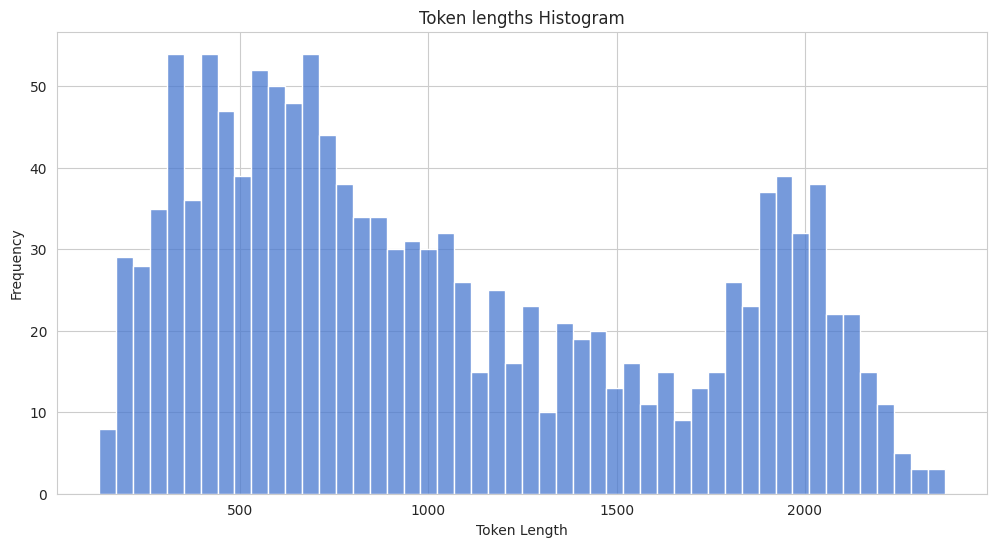

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_lengths, kde=False, bins=50)

# customize the plot info
plt.title("Token lengths Histogram")
plt.xlabel("Token Length")
plt.ylabel("Frequency")

plt.show()

In [83]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=80,  # number of tokens overlap between chunks
    length_function=tiktoken_len,
    separators=['.', '']
)

In [84]:
df['chunks'] = df['content'].apply(text_splitter.split_text)

In [85]:
# Explode the chunks list into individual rows, copying the wikiid and title values
df_exploded = df.explode('chunks').reset_index(drop=True)
df_exploded = df_exploded[['wikiid', 'title', 'chunks']]

In [86]:
df_exploded

,wikiid,title,chunks
0,deafbeef,Deafbeef,Deafbeef is a generative audiovisual NFT artis...
1,deafbeef,Deafbeef,"Deafbeef, who has a background in electrical e..."
2,deafbeef,Deafbeef,Areas of program memory that were not to be wr...
3,deafbeef,Deafbeef,Series 1 - Angular This collection of generati...
4,deafbeef,Deafbeef,The piece with the highest price was sold for ...
...,...,...,...
4785,blake-kathryn,Blake Kathryn,That detail preference quickly crafted the shi...
4786,blake-kathryn,Blake Kathryn,” Collaborations Kathryn signed a campaign wit...
4787,blake-kathryn,Blake Kathryn,"""Blake instantly understood my aesthetic and i..."
4788,blake-kathryn,Blake Kathryn,While the Seven Sirens video itself was posted...


In [65]:
filtered_df = df_exploded.loc[df_exploded['wikiid'].str.contains('lens-protocol')]
len(filtered_df)

3

In [66]:
n_df = df_exploded[df_exploded['wikiid'] == 'lens-protocol']
for index, row in n_df.iterrows():
    print(f"Content for wikiid 'lens-protocol': {row['chunks']}")

Content for wikiid 'lens-protocol': Lens Protocol is a composable, decentralized social graph on the Polygon proof -of-stake (PoS) blockchain allowing creators to control their content and data. It is a decentralized social network with a low carbon footprint and a web3 team. It allows users to retain ownership of their profiles and content, set up DAO accounts, monetize content, and transfer data. History Stani Kulechov, founder and CEO of Aave, created Lens Protocol based on discussions regarding the significance of digital identity control. Kulechov has expressed criticism of the way Web 2.0 social media platforms handle user data, restrict user content, and determine what information they view. Stani Kulechov discussed the evolution and revolution of the social media ecosystem at LisCon in 2021, and the team posted an open letter on the 20th of January, 2022 citing the problem of companies owning and monetizing their users’ content. The letter described Web 2.0 social media platfor

In [67]:
row_numbers = df_exploded.query("wikiid == 'lens-protocol'").index
print("Row numbers with wikiid 'lens-protocol':", list(row_numbers))

Row numbers with wikiid 'lens-protocol': [284, 285, 286]


In [68]:
tiktoken_len(df_exploded.iloc[284,2])

389

In [69]:
# Applying the tiktoken_len function to the content column and storing results in a list
token_lengths = [tiktoken_len(content) for content in df_exploded['chunks']]

# Calculate min, max, and average token lengths
min_token_length = min(token_lengths)
max_token_length = max(token_lengths)
average_token_length = sum(token_lengths) / len(token_lengths)

print(f"Minimum token length: {min_token_length}")
print(f"Maximum token length: {max_token_length}")
print(f"Average token length: {average_token_length}")

Minimum token length: 1
Maximum token length: 401
Average token length: 339.35114822546973


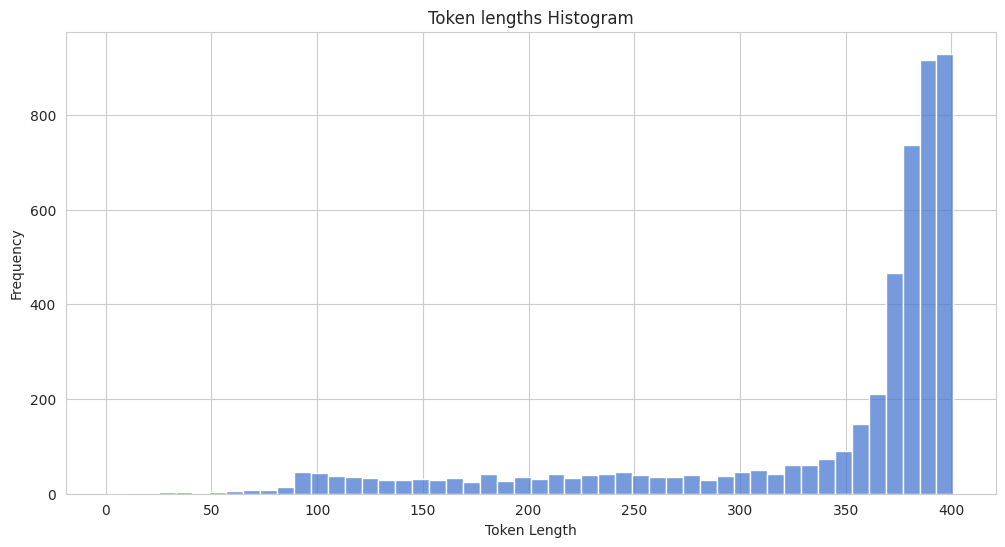

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_lengths, kde=False, bins=50)

# customize the plot info
plt.title("Token lengths Histogram")
plt.xlabel("Token Length")
plt.ylabel("Frequency")

plt.show()

In [52]:
!pip install supabase

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.4/216.4 KB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.4/134.4 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [53]:
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 KB 10.2 MB/s eta 0:00:00


In [54]:
import os
import openai
from getpass import getpass

openai.api_key = getpass()

··········


In [56]:
import numpy as np
import supabase
supabase_url = 'https://wpisaiqtaoykjwwszlan.supabase.co'
supabase_key = 'PRIVATE'
supabase_client = supabase.Client(supabase_url, supabase_key)

In [87]:
def get_embedding(text, engine="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=engine)['data'][0]['embedding']

In [81]:
def generate_embedding(row):
    content = row['chunks']
    return get_embedding(content)

In [88]:
for i in range(0, 4790):
    embeddings = get_embedding(df_exploded.iloc[i,2])
    supabase_client.table("langchain_split").insert({"wikiid":df_exploded.iloc[i,0], "title": df_exploded.iloc[i,1], "content": df_exploded.iloc[i,2], "embedding": embeddings }).execute()